Conclusions:

* `salesIndex` has 4 categories: 40, 44, 52, 53. The 44 and 52 categories are on 1.3% and 3.8% of the train data set. They are also rare in the items data set (so this is not just the result of certain items being rare).
* The lengths of the `order`-0 runs appear to have a geometric distribution, as if they are a waiting time. This seems like strong evidence that the `order`-1 runs are all part of a single order basket.


In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [2]:
library(ggplot2)

In [3]:
source("../src/data/read_dmc.R")

train = read_dmc("../data/train.csv")
items = read_dmc("../data/items.csv")

In [2]:
head(train, 10)

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
1,1.00,1.00,6570.00,0.00,2.00,14.60,1.00,0.00,0.00,16.89,0.00
2,2.00,1.00,14922.00,1.00,1.00,8.57,0.00,1.00,0.00,8.75,0.00
3,3.00,1.00,16382.00,0.00,1.00,14.77,0.00,1.00,0.00,16.06,0.00
4,4.00,1.00,1145.00,1.00,1.00,6.59,0.00,0.00,1.00,6.55,6.55
5,5.00,1.00,3394.00,0.00,1.00,4.39,0.00,0.00,1.00,4.14,4.14
6,6.00,1.00,3661.00,0.00,1.00,13.66,0.00,0.00,1.00,10.03,10.03
7,7.00,1.00,3856.00,1.00,1.00,3.03,0.00,0.00,1.00,3.58,3.58
8,8.00,1.00,16963.00,0.00,1.00,8.78,1.00,0.00,0.00,8.75,0.00
9,9.00,1.00,14560.00,0.00,1.00,10.84,1.00,0.00,0.00,12.04,0.00
10,10.00,1.00,4853.00,1.00,1.00,9.12,1.00,0.00,0.00,8.75,0.00


In [4]:
train$qty = train$revenue / train$price

In [5]:
df = train[1:100, ]

## Are order runs related to other features?

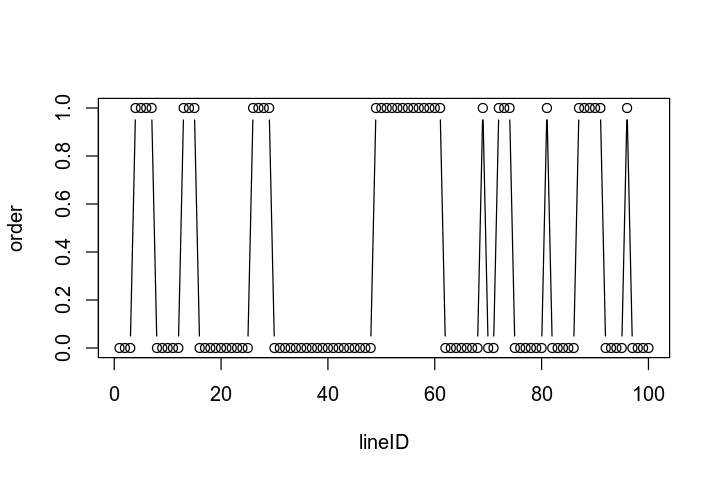

In [12]:
plot(order ~ lineID, df, type = "b")

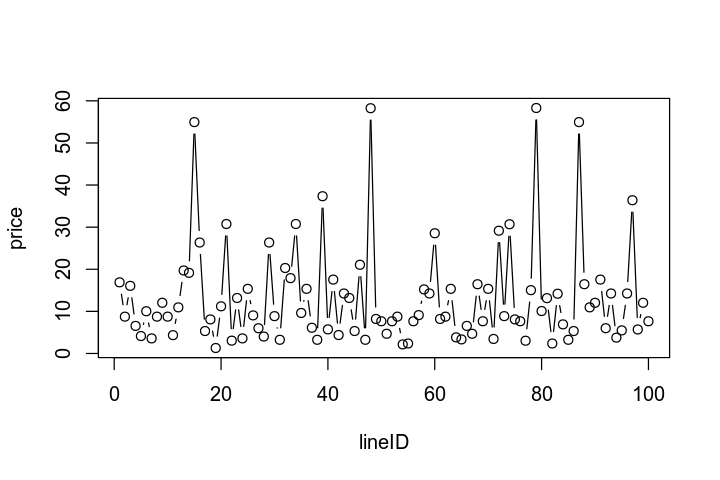

In [13]:
plot(price ~ lineID, df, type = "b")

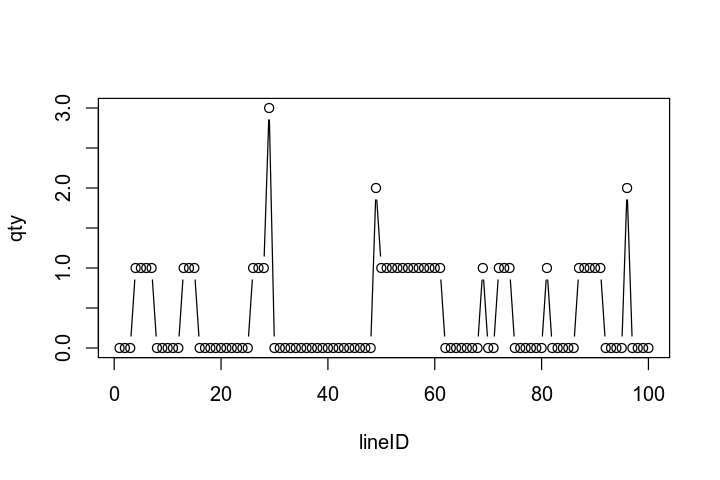

In [14]:
plot(qty ~ lineID, df, type = "b")

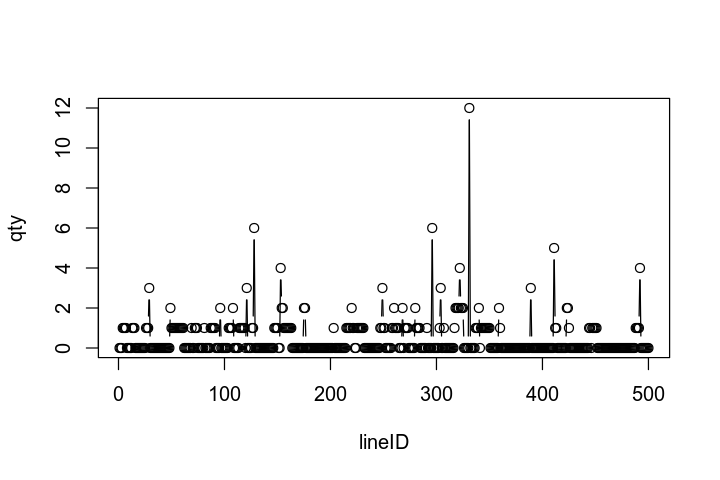

In [20]:
plot(qty ~ lineID, train[1:500, ], type = "b")

There are bursts of 1-item orders that sometimes contain a larger order. The `lineID` variable is just the row number, but is there something else (like item properties) that relates these orders?

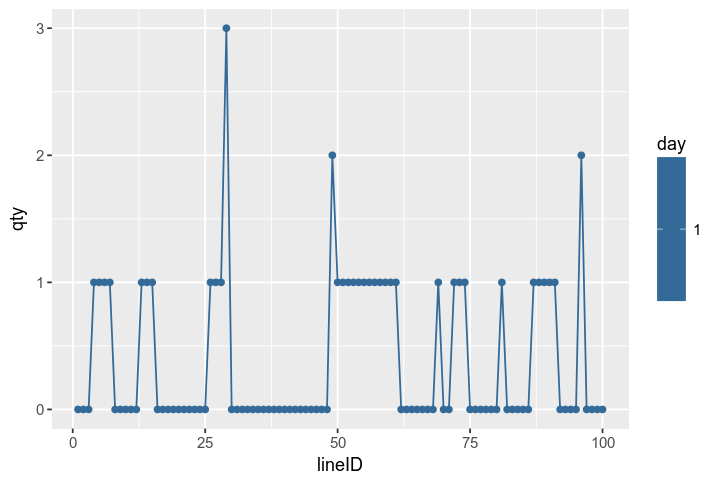

In [24]:
ggplot(df, aes(x = lineID, y = qty, color = day)) + geom_point() + geom_line()

In [30]:
pids = df$pid[1:7]
i = match(pids, items$pid)
cbind(items[i, ], order = df$order[1:7])

,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp,order
1,6570,255,2FOI,50,ML,TRO,0,40,193,NA,18.25,0
2,14922,18,1COJ0FIK,50,ST,TAB,1,40,66,C,18.81,0
3,16382,41,22OI7,2X50,ML,STI,0,53,40,NA,18.48,0
4,1145,52,18OZ00IS,60,G,GEL,0,40,25,NA,9.31,1
5,3394,90,20OI0,25X2,ST,KOM,0,53,14,NA,8.13,1
6,3661,90,13OX06,1000,ML,LOE,0,52,127,NA,21.6,1
7,3856,84,13OK0FOK,20,G,SAL,0,40,90,NA,5.62,1


There seem to be patterns in `salesIndex` and maybe `rrp`. The feature dictionary says `salesIndex` is the "dispensing regulation code", but what does that mean?

__Aside:__ What do the various units mean? ML and G are probably grams and milliliters, but what is ST?

In [38]:
i = match(df$pid, items$pid)
df$salesIndex = items$salesIndex[i]
df$rrp = items$rrp[i]

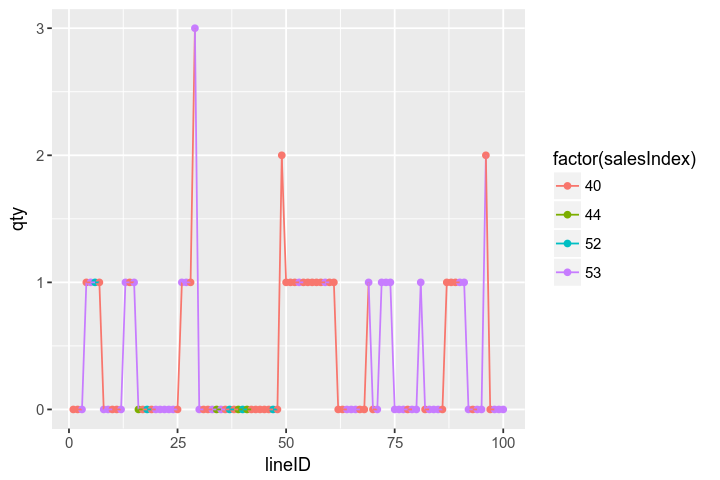

In [37]:
ggplot(df, aes(x = lineID, y = qty, color = factor(salesIndex), group = 1)) + geom_point() + geom_line()

The `salesIndex` is mostly 40 and 53. Are there only four categories?

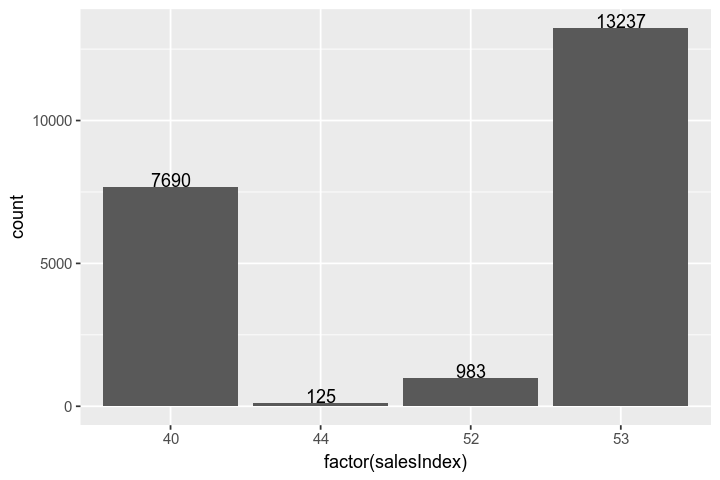

In [50]:
ggplot(items, aes(factor(salesIndex))) + geom_bar() + geom_text(stat = "count", aes(label = ..count..), vjust = 0)

In [51]:
ii = match(train$pid, items$pid)

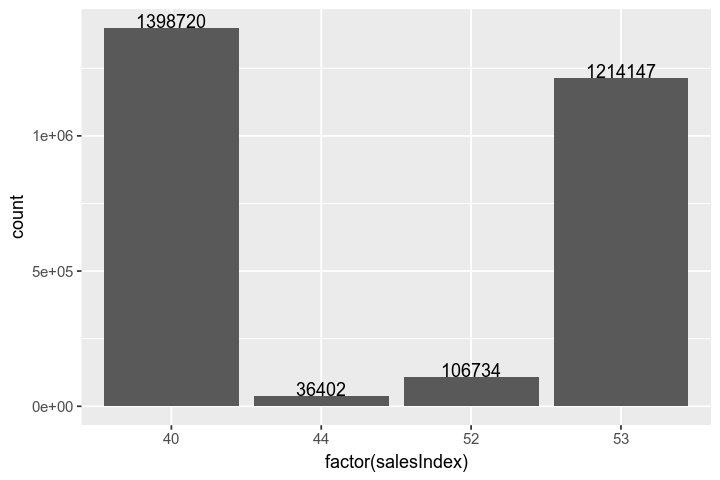

In [57]:
salesIndex = items$salesIndex[ii]
ggplot() + aes(factor(salesIndex)) + geom_bar() + geom_text(stat = "count", aes(label = ..count..), vjust = 0)

In [58]:
prop.table(table(salesIndex))

salesIndex
        40         44         52         53 
0.50751759 0.01320826 0.03872782 0.44054633 

So the pattern in `salesIndex` doesn't seem to have anything to do with `order`.

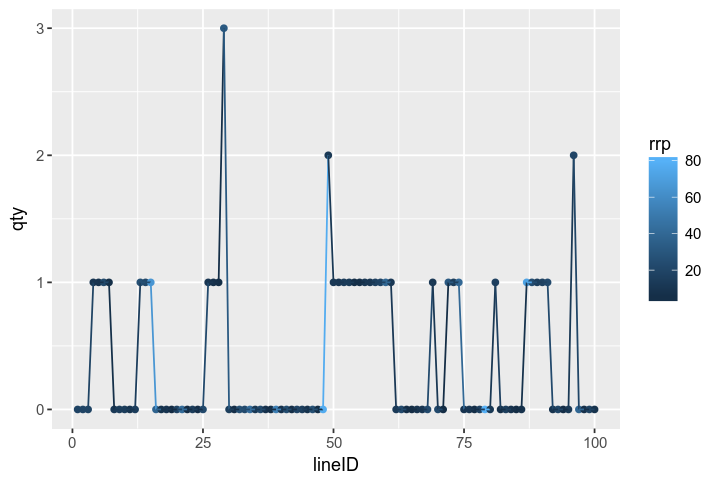

In [39]:
ggplot(df, aes(x = lineID, y = qty, color = rrp)) + geom_point() + geom_line()

## Run Length & Composition

In [6]:
# Find the start and end points of each run.

runs = cumsum(head(train$order, -1) != tail(train$order, -1))
runs = c(0, runs)
#rbind(runs, df$order)

In [7]:
# How long are the runs?

lengths = table(runs)

In [29]:
run_type = as.numeric(names(lengths)) %% 2
run_df = data.frame(length = c(lengths), order = run_type)
head(run_df)

,length,order
0,3,0
1,4,1
2,5,0
3,3,1
4,10,0
5,4,1


In [14]:
summary(run_df$length)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   7.383   8.000 645.000 

Warning message:
: Removed 2842 rows containing non-finite values (stat_count).Warning message:
: Removed 2842 rows containing non-finite values (stat_count).

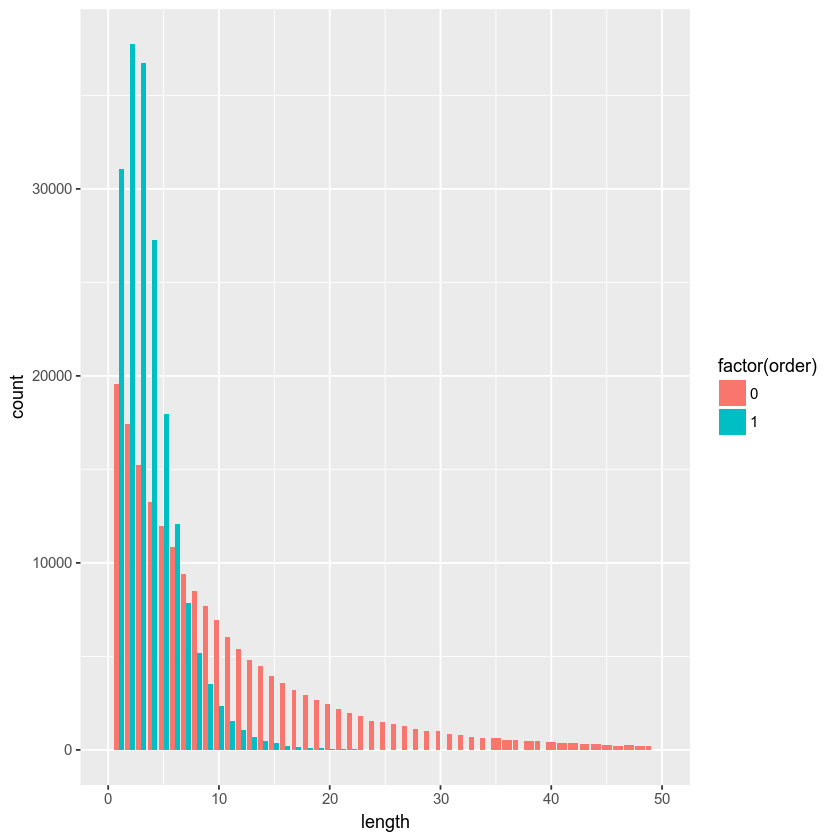

In [38]:
plt = ggplot(run_df, aes(length, fill = factor(order))) + geom_bar(position = "dodge") + xlim(0, 50)
ggsave("run_length.png", plt, "png", "../junk", width = 4, height = 4)
plt

There are lots of long order-0 runs. The decay looks exponential. Maybe we should think of this as a (geometric) waiting time.

Some things to investigate:
* Do runs have similar products? Are the natural clusters of order-1 runs (different kinds of order baskets)?
* How does each order-1 run relate to the preceeding order-0 run?
* Total basket values

In [39]:
# How can we identify products that tend to be in baskets together?
#
# Count pairs of products that appear together

by_run = split(train, runs)

In [82]:
n_pid = max(train$pid)
pids = matrix(0, n_pid, n_pid)

In [ ]:
# Very slow (there's probably a better way):
for (i in seq_along(by_run)) {
    idx = t(combn(sort(by_run[[i]]$pid), 2))
    pids[idx] = pids[idx] + 1L
}